# CNN Model

- input = image

- output = score (Mean Vol After Open / Mean Vol Before Open) 

### 0. Installation (torch & fastai)

In [2]:
# pip install torch===1.7.0 torchvision===0.8.1 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
# pip install fastai

  Using cached fastai-2.2.5-py3-none-any.whl (191 kB)
  Using cached spacy-2.3.5-cp37-cp37m-win_amd64.whl (9.5 MB)
  Using cached fastprogress-1.0.0-py3-none-any.whl (12 kB)
  Using cached fastcore-1.3.19-py3-none-any.whl (53 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# pip install --upgrade pip

In [1]:
#pip show fastai

Name: fastai
Version: 2.2.5
Summary: fastai simplifies training fast and accurate neural nets using modern best practices
Home-page: https://github.com/fastai/fastai/tree/master/
Author: Jeremy Howard, Sylvain Gugger, and contributors
Author-email: info@fast.ai
License: Apache Software License 2.0
Location: /home/sehara/.local/lib/python3.7/site-packages
Requires: torchvision, scikit-learn, pyyaml, packaging, matplotlib, pandas, scipy, pillow, fastprogress, spacy, torch, requests, fastcore, pip
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from fastai.vision.all import *
from fastai.metrics import error_rate

In [2]:
torch.cuda.empty_cache()

In [3]:
# print(torch.version.cuda)

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.set_device(0)

In [6]:
torch.cuda.get_device_name()

'GeForce 940MX'

### 1. Data Prep

In [7]:
data = (ImageDataLoaders.from_csv('../data/imgs', 'image_label_dir.csv', valid_pct=0.2, seed=10, size=224, num_workers = 0))
#         .random_split_by_pct(valid_pct=0.2, seed=10))
#         .split_by_idxs(list(range(400)), list(range(400,496))))
#                  .label_from_df()
#                  .databunch())

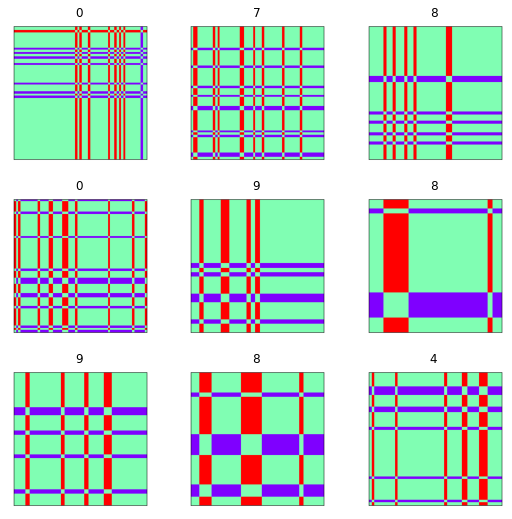

In [8]:
data.show_batch()

In [3]:
# data.show_batch(rows=3, figsize=(4,4))

### 2. cnn model

In [16]:
# data = data.normalize()

In [9]:
n_batch= 20

learner = cnn_learner(data, models.resnet34, loss_func=mae, metrics=error_rate).to_fp16()
# learner.model[1]

### Tuning Model

In [13]:
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 1.21 GiB already allocated; 6.93 MiB free; 1.24 GiB reserved in total by PyTorch)

In [10]:
### Finding learning rate
learner.lr_find()
learner.recorder.plot(suggestion=True)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 1.21 GiB already allocated; 6.93 MiB free; 1.24 GiB reserved in total by PyTorch)

In [ ]:
mingradlr = learner.recorder.min_grad_lr